# Name clustering and prediction:

Project goal: Predict what name trends will occur in a given year, based on the name properties I have calculated in the prior analysis.

## Preprocessing: Import libraries, generate variables

In [1]:
#Import (most) necessary libraries

import numpy as np
import pandas as pd
import csv
import os
import time
import datetime as dt
import distance #Using the distance module for Levenshtein difference

import matplotlib.pyplot as plt

import pickle

import requests
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession

pd.set_option('display.max_rows',150)

In [2]:
%config Completer.use_jedi = False
#Autocomplete has been finicky, switching versions. 

In [3]:
#Import preprocessed data generated in "Names_calculate_reduced"
#or prior actuarial calculations.

#Data structures from prior actuarial, modified in Names_calculate_reduced:

alive_F = pd.read_pickle('./processed_variables/life_F_df2.pkl')
alive_M = pd.read_pickle('./processed_variables/life_M_df2.pkl')


#Generated in 'Names_calculate_reduced':

#Total births, from SSA:
totalnames_table = pd.read_pickle('./processed_variables/Total_soc_cards.pkl')

# #Names dataframe, HANDLED BELOW
# names_df = pd.read_pickle('names_df.pkl')
# names_df_trim = pd.read_pickle('names_df.pkl')

#Year of birth data:
namelife_M_yob = np.load('./processed_variables/namelife_M_yob.npy')
namelife_F_yob = np.load('./processed_variables/namelife_F_yob.npy')
#"Base" life data (total of all ages alive each year):
namelife_M_base = np.load('./processed_variables/namelife_M_base.npy')
namelife_F_base = np.load('./processed_variables/namelife_F_base.npy')
#"Name" data: the names associated with each element:
namelife_M_name = np.load('./processed_variables/namelife_M_name.npy', allow_pickle=True)
namelife_F_name = np.load('./processed_variables/namelife_F_name.npy', allow_pickle=True)
#"Birth" data: the base how-many-per-year for all names:
namebirth_M = np.load('./processed_variables/namebirth_M.npy')
namebirth_F = np.load('./processed_variables/namebirth_F.npy')

In [4]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files,
#containing all names with over 5 births for the year "YYYY", 
#the four-digit year 
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html, I
#manually downloaded the national zip file that unpacks to a 
#folder containing the files below, renamed "names_wYYYY", where
#"YYYY" is the four-digit year of the 

#REFRESH EVERY TIME. The "names_df" and "names_df_trim" data 
#structures take up just over 100MB, so they do not play nice 
#with Github. Takes maybe 10 seconds.

refresh = True

if refresh:

    #Drop down into the correct directory,
    os.chdir('../Names/names_w2020')
    #grab a list of the files in it,
    current_dir = os.listdir()

    names_temp = []
    #step through them, loading and appending
    for ftemp in current_dir:
        if ftemp[-3:] == 'txt':
            dftemp = pd.read_csv(ftemp, names=['Name','Sex','Number'])
            dftemp['Year'] = int(ftemp[3:-4])
            names_temp.append(dftemp)

    #chop them all together
    names_df = pd.concat(names_temp)
    names_df.info()

    #go back up
    os.chdir('..')


    #Reset the indexes to unduplicate them, since each stack was indexed 
    #separately; keeping the old indices is handy though, so default
    #'drop = false' option is kept.

    #Yes, the sorting matters. It makes plotting way easier later on, and
    #I could definitely use it to speed up the name structure indexing. 

    names_df = names_df.reset_index().sort_values(['Name','Year'])



    #"names_df" is raw, not controlled for population or births. What was 
    #the total as a fraction of the year's name births? Currently only
    #using the total names included in this data as the core comparison.
    #Could pull from the social security total above in future changes.

    year_total = names_df.groupby('Year').sum()

    #Join year_total w/ names_df to get what fraction of named births
    #that year made up of the given name/sex pair:
    names_df = pd.merge(left=names_df, right=totalnames_table, 
                        left_on='Year', right_on='Year of birth', 
                        how='left')
    names_df['Fraction'] = names_df['Number']/names_df['Total']

    #Not normalizing to separate male or female births, only total.
    #Possibly another future improvement, since the likelihood of 
    #registering males/females appears to have been biased early on. 
    names_df.drop(columns=['Male','Female','Total'], inplace=True)

    #Calculate total number of births for each name:
    totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

    trimvalue = 20
    #Limit dataset to names that had more than 20 total births
    #with that name:
    keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

    #Join on name/sex pairs to keep only ones included above
    names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
    #Handling number column ambiguity, not pretty but works fine
    names_df_trim['Number'] = names_df_trim['Number_x']
    names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
    val1 = len(names_df.groupby(['Name','Sex']).size())
    val2 = len(names_df_trim.groupby(['Name','Sex']).size())
    val1a = len(names_df)
    val2a = len(names_df_trim)

    #Display results
    print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
    print('Total names (total M/F separately):')
    print(val1, '->', val2)
    print('Total name/year records:')
    print(val1a, '->', val2a)
    print('\nRemoves {:.2f} of names while removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

    #names_df.to_pickle('names_df.pkl')
    #names_df_trim.to_pickle('names_df_trim.pkl')
    
else:
    names_df = pd.read_pickle('names_df.pkl')
    names_df_trim = pd.read_pickle('names_df.pkl')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020863 entries, 0 to 32029
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 77.1+ MB
Pretrim -> posttrim, minimum 20 births:

Total names (total M/F separately):
111472 -> 70589
Total name/year records:
2020863 -> 1956469

Removes 0.37 of names while removing 0.032 of total birth records.


## Step 1: Name Clustering

**The goal:** Find names that are similar to one another in their properties as words in order to identify name trends. In the example in the prior analysis (`Names_visualize`), you may have noticed that both "Darin" and "Darrin" were characteristic names. This is common! The name "Abigail", for example, has been spelled at least a dozen different ways. If we treat all these names as independent, we may miss the broader-trend forest for the specific-spelling trees. **In this step, we'll cluster names based on how similarly they are spelled or pronounced.** 

Let's start with the spelling. I'll be using Levenshtein distance, a very well-characterized measure of how similar two words are to one another. It's also known as the "edit distance", since it measures the number of single-character insertions, deletions, or substitutions it takes to get from one word to another. Its simplicity is its strength, but it also means that Levenshtein distances doesn't take into account whether any given pair of letters are more similar (i.e. "a" is much more like "e" than "q"). 

The Levenshtein distance gives a relative difference between each word, which means we're looking for a method that isn't based on absolute position. **The core clustering method we'll use is affinity propagation**. For that, we will need to calculate a how similar every word is to every other word. 

Minor problem: Using the current set of names, the number of comparisons needed to calculate a complete distance matrix is big. The **total number of comparisons is O(n²)**, which is not great when you have a set of 100,000 names. This is one key reason for pruning the dataset. Second, limiting the dataset also improves the likelihood that our clustering method converges. From practical testing, it appears that when given any single Levenshtein distance measure, the dataset is unlikely to converge if it contains more than a few thousand items (see next section for more detail). To trim the dataset, I'll be focusing on the most relevant names, which met a certain threshold of use. This trimming occurs on top of an earlier dataset reduction, which only kept names with at least 20 nameholders born. 

In summary, to make our clustering faster and more functional, **we'll limit our dataset again, based on peak holders alive.** In the plots below, I show how some additional thresholds affect the number of names. 

This does not prevent us from analyzing additional names after the fact! For a new name, we can easily calculate which existing cluster it should be part of (for example, lowest average Levenshtein distance from all members of that cluster), but the automatic detection of clusters itself does not work as nicely. Given the matrix size and the limitations of our distance estimate, this may be close to what we can practically get away with using a *single* Levenshtein distance and affinity propagation. 

### Code subsections:
**- Trimming the dataset**  
**- Gathering pronunciations**  
**- Calculating name distances**  
**- Clustering**  

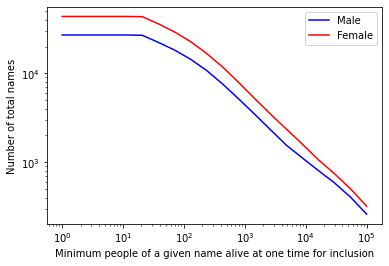

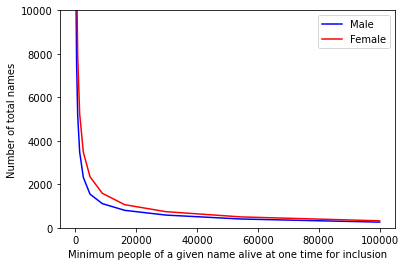

Note: set is previously trimmed to only names with at least 20 born,
which is why there's a sharp shoulder at 20 alive
Total male names >50: 20482
Total female names >50: 33056
Total male names >6000: 1371
Total female names >6000: 2022


In [5]:
#TRIMMING THE DATASET:

#Compare how many names you keep, depending on your cutoff threshold
#for minimum number of holders (requires hand-tuning, takes a couple
#seconds to run)

n_years = namebirth_M.shape[1]

commons_list_M = []
commons_list_F = []
#Test thresholds of 1-100000, using 20 log steps
testvals = np.logspace(0,5,20)
for n in testvals:
    commons_list_M.append(sum(namelife_M_base.max(1) > n))
    commons_list_F.append(sum(namelife_F_base.max(1) > n))
    
plt.loglog(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.legend(['Male','Female'])
plt.show()
plt.plot(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.legend(['Male','Female'])
plt.ylim([0,10000])
plt.show()

#A couple specific test values:
thresh1 = 50
thresh2 = 6000
commons_M_1 = namelife_M_base.max(1) > thresh1
commons_F_1 = namelife_F_base.max(1) > thresh1
commons_M_2 = namelife_M_base.max(1) > thresh2
commons_F_2 = namelife_F_base.max(1) > thresh2

#Total names:
print('Note: set is previously trimmed to only names with at least 20 born,\nwhich is why there\'s a sharp shoulder at 20 alive')
print('Total male names >{}: '.format(thresh1) + str(sum(commons_M_1)))
print('Total female names >{}: '.format(thresh1) + str(sum(commons_F_1)))
print('Total male names >{}: '.format(thresh2) + str(sum(commons_M_2)))
print('Total female names >{}: '.format(thresh2) + str(sum(commons_F_2)))

### The problem of distance estimation, in detail:

What is it about our distance estimation that may cause problems? Levenshtein distances are very quantized. All the distances between words are integers. There are a lot of names with a distance of 1, 2, or 3, for example, which means there aren't any smooth grades of difference that let the algorithm find a good threshold to separate them. Consider, for example, whether "Chris" is closer to "Cris" or to "Caris". We'd probably say the former, but the spelling distance (1) is identical. Even with normalized Levenshtein, which measures the fraction of the word that is changed, there are many similar distances between different name pairs (like the prior example, for one direction), which is likely to cause problems for any clustering method. 

There are several ways we could approach this problem. One it to simply find more dimensions along which we can compare distance! If a comparison name is the same distance away in spelling, it may be closer or farther in pronunciation, which gives us the potential for much smoother grades of difference. (Figuring out pronunciation for a name is difficult, but I found a reasonable way to offboard it. Let's continue, assuming we have pronunciation information.)

First, we could use the Levenshtein distances across IPA pronunciation of each name, rather than spelling. The IPA pronunciation for Chris, for example, is "krˈɪs", with one character for each included sound. Looking at the number of insertions/deletions/substitutions of sounds between names is a good way to measure how similar names are, and is at least partially independent from their character differences. The IPA pronunciation works great when compared using a basic Levenshtein distance, since each character is a sound, and additions and subtractions make sense. However, it still runs into the same problem we had with spelling: there's no naive way to tell *how* similar individual characters are, despite, for example, "bee" being closer to "bye" than to "br".

Second, then, we could implement a similarity metric using ARPABET pronunciation. The ARPABET pronunciation for Chris is "K R IH1 S". You may notice that that vowel has a lot more characters. The ARPABET model contains useful information about sound similarity, just from the overlap between the characters present in each sound's code. We could use this directly: The prior comparison of Chris, "K R IH1 S", vs. Caris, "K AE1 R IH0 S", however, shows a minor downside of that. Individual characters do not represent individual sounds. The ARPABET Levenshtein distance  may over or underestimate how far apart words with different sounds are, depending on the number of characters used to represent the sound. 

So... what do we do with ARPABET? First, it's important to note that the problem I mentioned above isn't prohibitive! Basic Levenshtein on ARPABET still gives us a different perspective about name similarity, even if it's what you might call a noisy signal. 

In short, we have a problem and an opportunity: Pronunciation data has some of the same quantization challenges as spelling data, but we also know that some sounds are more like one another, which our current edit distance misses. Here, before I just use the simple solution and call it a day, I'll talk about how I could implement more precise, high-effort solutions.

### High-effort solutions:

#### ARPABET multi-level distance measures:
If ARPABET represents individual sounds with varying sets of characters, perhaps we could measure distance on multiple levels: calculate character distances between individual sounds, then use those distances to calculate how far apart aggregate collections of sounds are. 

One relatively simple way would be doing normalized character difference rather than total character substitution. For example, the "A" in "Adrian" is represented by "EY1", compared to the "A" in "Andrew" which is "AE1". Using standard Levenshtein edit distance between these two ARPABET representations of the characters, we could for example make one deletion (EY1 -> E1) and one insertion (E1 -> AE1). To go from EY1 to AE1 is be a Levenshtein distance of 2, or a normalized Levenshtein distance of 0.66 (fraction of characters changed).

That's not great, since it gives a distance of 0.66 between the two characters despite pretty similar sounds, but it's still more effective than the full 1.00 distance that IPA pronunciation without custom character differences would give. We could also ignore the order of the letters, and do a simple character-similarity measure, which would give us a 0.33 distance, but I'd have to look into whether this would give spurious correlations between unrelated sounds. Once you're at the level of sounds, sound insertion/deletion would still be a binary scale, but substitutions could be more nuanced. Unfortunately, this solution would also require a modified Levenshtein-like implementation to use this multi-level system, (or similarly in-depth investigation of alternative solutions to see which could be adapted for this purpose).

#### IPA weighted distance using sound similarity:
Instead of developing a new multi-level version of the Levenshtein distance, it would be easier to characterize how similar the IPA sounds are, and use a single-level Levenshtein with weighted substitutions. However, finding quantitative differences between IPA characters is not trivial. I was able to find a paper that looks like it does a good job measuring how far apart different vowels are using both text-similarity and pronunciation-similarity methods, [by Wieling et al (2012)](http://www.martijnwieling.nl/files/WielingMargarethaNerbonne2012.pdf). Unfortunately, while the methods are very interesting and the results look good, the paper does not provide a straighforward distance matrix. The sound distances could be partially reconstructed from Figure 3, but, again, starting to get a bit past the scope of the project.

#### Both rely on weighted Levenshtein at the top level:
In either case, the differences between sounds vary, with some being closer and some farther, as mentioned above. At the level of the name as a series of sounds, this calls for a weighted Levenshtein, where different distances are no longer all 1. Fortunately, this problem is fairly well-studied, and there appear to be [multiple toolboxes that implement it](https://stackoverflow.com/questions/6080958/ocr-weighted-levenshtein-distance), such as the ["weighted-levenshtein" package](https://pypi.org/project/weighted-levenshtein/). 

### High effort options are out there, but why not go simple?
I've laid out two potential solutions for calculating pronunciation similarity, but implementing these is beyond the scope of this project. Instead, I use a very "data science"-type solution: **Solve the problem in a passable way using several different easy methods, then build a model that uses them all.** Here, I calculate name distances based on three measures: spelling edit distance, IPA edit distance, and ARPABET edit distance. I slightly decreased the weight of the pronunciation measures relative to spelling, since both pronunciation options should be measuring the same thing. 

While each individual measure is quantized, combining this set of three measures gets us a very wide range of potential distances. Compared to the roughly 1-12 options from the raw spelling edit distance, there are many more now possible, and we have a great deal more uniqueness in our word distances. 

*POTENTIAL FUTURE CHANGE:* 
*Pre-group names with identical predicted pronunciations, then get the top set. That will, for example, catch the "Abigail" complex under a single umbrella, or the "Brayden/Breighdon" etc. name clan.*


### Gathering pronunciations:

To do anything with pronunciation distance, we have to actually get the pronunciations. Rather than trying to develop or implement my own text-to-speech converter for arbitrary collections of English letters, I used an existing API to get estimated pronunciations for each name. Datamuse is one of the oldest Internet dictionaries, which means it's accumulated some interested features over the years. The API has very in-depth options, as described in [the extensive documentation](https://www.datamuse.com/api/). Unlike some sources, it gives estimates for arbitrary words, not just those included in established sources like the [Carnegie Mellon Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict). It does fairly well, though some names get lumped in with related names as the same pronunciation. Abrielle, for example, comes out as identical to Gabrielle, because it was close enough that the tool guessed it has a leading G. These occasional questionable pronunciations are a clear disadvantage of this method, but it's a very useful tool considering. 

*Personally, I often rely on hearing others to know a name's correct pronunciation, rather than determining it from text. English pronunciation is hard enough already, since you have to have heard a word to be reliably accurate, even knowing which contributing language a word came from. Names are no easier.*

In [6]:
#GATHERING PRONUNCIATIONS:

#Example API: https://api.datamuse.com/words?sl=mackenzie&md=r
#This API call returns both a word's pronunciation and words that
#sound like it.

import string
from ediblepickle import checkpoint

#Getting all pronunciations takes a lot of API calls. To cut down
#on the time, this function is checkpointed, and the function 
#responses are stored in a "name_pronunciation_storage" folder.

@checkpoint(key=string.Template('name_pronunc_{0}_{1}.pkl'), work_dir='name_pronunciation_storage', refresh=False)
def get_name_pronunc(name, sex):
    #Define core API call, which works great with the word itself at the end
    baseapi = 'https://api.datamuse.com/words?md=r&ipa=1&sl='
    #Get page response for api+name.
    
    #V1: Use futuressessions
    #REQUIRES THAT A FUTURESSESSION BE ACTIVE! "session = FuturesSession()"
    resp = session.get(baseapi + name)
    #Pull out just the content
    pagecont = resp.result().content
    pagetext = resp.result().text
    
    #V2: Use a standard request
    #resp = requests.get(baseapi + name)
    #pagecont = resp.content
    #pagetext = resp.text
    
    #Fairly messy way to do this, probably ought to use a class
    sylstart = pagetext.find('numSyllables')
    syl = int(pagetext[sylstart+14])
    arpastart = pagetext.find('pron:')
    arpastop = pagetext.find('"', arpastart)
    arpa = pagetext[arpastart+5:arpastop]
    ipastart = pagetext.find('ipa_pron:')
    ipastop = pagetext.find('"', ipastart)
    ipa = pagetext[ipastart+9:ipastop]
    
    #print(ipa)
    pronunc = []
    pronunc.append(syl)
    pronunc.append(arpa)
    pronunc.append(ipa)
    time.sleep(0.05)

    return pronunc, pagetext

In [7]:
%%time

redo_pronunc = False
#Should functionize this. 
#Note that this script runs names that appear in both male and
#female name lists twice. Because the load process is very 
#quick, I have not optimized it out.
#
#Script run times and storage:
#1. If the data is loaded from the all_pronunciations pickle
#   files, the script takes less than a second. 
#2. If the data is reloaded but restored from checkpoints,
#   the script takes about a minute. 
#3. If the data is not checkpointed yet, the base collection
#   takes multiple hours, and writes a folder containing 110k
#   items, which take up about 1GB of memory. The data storage
#   is overkill: it includes information about similar words,
#   but we are currently only using the pronunciation data for
#   the target word. If it saves rerunning this fresh, though,
#   that extra memory is WELL worth it. 

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_F = {}
    all_pagecont_F = []

    for name in namelife_F_name:
        pronunc, pagecont = get_name_pronunc(name, 'F')
        all_pronunciations_F[name] = pronunc
        all_pagecont_F.append(pagecont)
        
    with open('./processed_variables/all_pronunciations_F.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_F, fname)
        
else:
    with open('./processed_variables/all_pronunciations_F.pkl', 'rb') as fname:
        all_pronunciations_F = pickle.load(fname)

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_M = {}
    all_pagecont_M = []

    for name in namelife_M_name:
        pronunc, pagecont = get_name_pronunc(name, 'M')
        all_pronunciations_M[name] = pronunc
        all_pagecont_M.append(pagecont)
        
    with open('./processed_variables/all_pronunciations_M.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_M, fname)
        
else:
    with open('./processed_variables/all_pronunciations_M.pkl', 'rb') as fname:
        all_pronunciations_M = pickle.load(fname)
    

CPU times: user 60.9 ms, sys: 4.1 ms, total: 65 ms
Wall time: 65.7 ms


#### General name fitting notes:

Time course-based analysis like this could be done using a RNN (Recurrent Neural Network) via the Tensor Flow library, it's well-implemented in Keras. This is a good future modeling opportunity. 


#### Possible predictive analyses:

1. Predict with a linear model how popular a given name is expected to be in a given year, based on popularity of other names and the name's own popularity in the past. What are some potential downfalls? There are a large number of names, and 140 data points. Overfitting could be a problem. It may be a good idea to predict using aggregated trends, rather than individual name trends, by clustering names based on spelling/pronunciation similarity, then predicting based on trends for clusters rather than individual names. 

2. Predict name frequency in a given year based on number and ages (or age structure) of each other name currently alive. This would add many more variables to an already variable-rich fit, but could be very interesting: generational name trends would be easy to account for by this method. However, a lot of this data could largely be accounted for with the panel regression, as simple negative relationships between name frequencies would explain it.

3. Predict name trends using Panel Linear Regression. This is probably the most appropriate, given the data types and properties that we have. I'll be relying in part on a [writeup of Panel Data Regression in Python](https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8) that covers a lot of the potential pitfalls. It may also be worth considering a [missing-data implementation](https://www.researchgate.net/publication/349523278_Bayesian_estimation_and_model_comparison_for_linear_dynamic_panel_models_with_missing_values), but that version is probably not necessary: we have nearly-complete data for our subset of names here, if we assume that years with less than 5 births of any given name are effectively zero. 


#### Other considerations:

- Clustering methods: Currently uses spelling/pronunciation, as mentioned above, but we could also use the time course correlation between different names over time. Just calculate the correlation matrix between all the name-births time series. This would allow name grouping based on trends, not spelling/pronunciation, and could be included as a third measure for distance, or as a separate clustering method. It might also be good to look at "typical" correlations, over say a 20-30 year span

- Alternative clustering methods: Spectral Clustering, Markov Clustering (MCL), other distance-based rather than position-based clustering. We really don't have an absolute position estimate at all here, it's all relative. 

- More detailed name spelling/pronunciation comparison: Customized or weighted Levenshtein would be a possible option, as described in earlier notes. NLP could also be useful, with (for example) bag-of-words comparison for individual letters and letter bigrams, rather than word/word bigrams. Keeping capitals would also be very helpful. 

- Partially-manual clustering: Names with *identical* pronunciation are automatically clustered, then the remaining names and name clusters are used as the base for affinity propagation clustering. 

- Clustering time-series!
https://www.researchgate.net/publication/4756297_Model-Based_Clustering_of_Multiple_Time_Series.
Looks like it would be some work to implement, but potentially really interesting. 

In [8]:
#Example name comparison

testname1 = 'Andrew'
testname2 = 'Adrian'

print('Example name comparison, spelling vs. sounds:\n')
print(testname1)
print(all_pronunciations_M[testname1])
print(testname2)
print(all_pronunciations_M[testname2])
print('\nDistances:\nSpelling Lev:')
print(distance.nlevenshtein(testname1,testname2))
print('IPA Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][2], all_pronunciations_M[testname2][2]))
print('ARPABET Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][1], all_pronunciations_M[testname2][1]))

sound1 = all_pronunciations_M[testname1][1].split()[0]
sound2 = all_pronunciations_M[testname2][1].split()[0]
print('(ARPABET first sound Lev: ' + sound1 + ' vs ' + sound2 + ')')
print('(', distance.nlevenshtein(sound1, sound2), ')')

Example name comparison, spelling vs. sounds:

Andrew
[2, 'AE1 N D R UW0 ', 'ˈændru']
Adrian
[3, 'EY1 D R IY0 AH0 N ', 'ˈeɪdriʌn']

Distances:
Spelling Lev:
0.6666666666666666
IPA Lev:
0.625
ARPABET Lev:
0.6111111111111112
(ARPABET first sound Lev: AE1 vs EY1)
( 0.6666666666666666 )


In [9]:
#Define the nametest sets, using threshold from above:

#Trimmed from >5000 to >6000, which keeps the all-names 
#distance structures under 100MB. 
thresh=6000

nametest_M_inds = namelife_M_base.max(1) > thresh

nametest_M_name = namelife_M_name[nametest_M_inds]
nametest_M_pronI = pd.Series([all_pronunciations_M[tempname][2] for tempname in nametest_M_name])
nametest_M_pronA = pd.Series([all_pronunciations_M[tempname][1] for tempname in nametest_M_name])
nametest_M_num = namelife_M_base[nametest_M_inds].max(1)
nametest_M_birth = namebirth_M[nametest_M_inds,:]

nametest_F_inds = namelife_F_base.max(1) > thresh
nametest_F_name = namelife_F_name[nametest_F_inds]
nametest_F_pronI = pd.Series([all_pronunciations_F[tempname][2] for tempname in nametest_F_name])
nametest_F_pronA = pd.Series([all_pronunciations_F[tempname][1] for tempname in nametest_F_name])
nametest_F_num = namelife_F_base[nametest_F_inds].max(1)
nametest_F_birth = namebirth_F[nametest_F_inds,:]

#All names test set:
nametest_S_name = np.concatenate([nametest_M_name, nametest_F_name])
nametest_S_pronI = np.concatenate([nametest_M_pronI, nametest_F_pronI])
nametest_S_pronA = np.concatenate([nametest_M_pronA, nametest_F_pronA])
nametest_S_num = np.concatenate([nametest_M_num, nametest_F_num])
nametest_S_birth = np.concatenate([nametest_M_birth, nametest_F_birth])

print('Names in set:\n',
      'M: ', nametest_M_name.shape[0], '\n',
      'F: ', nametest_F_name.shape[0], '\n',
      'S: ', nametest_S_name.shape[0], '\n')

Names in set:
 M:  1371 
 F:  2022 
 S:  3393 



In [10]:
%%time
#CALCULATING NAME DISTANCES

#Despite the long preamble, the final distance math
#I settled on is straightforward. You calculate the 
#normalized Levenshtein distance between each pair of
#names. Simple to code, but expensive to run, so I'm
#serializing the variables afterwards for loading.
#Using a threshold of >5000 nameholders alive, which
#limits the data to 1500M/2300F, the distance math
#takes a couple hours if you do M/F/S, where "S" has
#both.

#I did look to see if there was a decent matrix math
#option that would speed it up, but wasn't able to find
#anything for this library. 

#Note: Calculating the ARPABET distance (pronA) takes
#noticeably more time than spelling (name) or IPA (pron),
#since the strings are a lot longer. Might be worth 
#taking out the spaces?


#LIST COMPREHENSION VERSION EATS TOO MUCH MEMORY
# lev_similarity_name_M = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_name] for nameM2 in nametest_M_name])

#This ought to be done with a class, but copy-paste
#works quickly, and we'll be running a limited set.

n_names_M = nametest_M_name.shape[0]
n_names_F = nametest_F_name.shape[0]
n_names_S = nametest_S_name.shape[0]

#Build arrays to write to
levdif_name_M = np.zeros([n_names_M, n_names_M])
levdif_pronI_M = np.zeros([n_names_M, n_names_M])
levdif_pronA_M = np.zeros([n_names_M, n_names_M])
levdif_name_F = np.zeros([n_names_F, n_names_F])
levdif_pronI_F = np.zeros([n_names_F, n_names_F])
levdif_pronA_F = np.zeros([n_names_F, n_names_F])
levdif_name_S = np.zeros([n_names_S, n_names_S])
levdif_pronI_S = np.zeros([n_names_S, n_names_S])
levdif_pronA_S = np.zeros([n_names_S, n_names_S])

refresh = False

if refresh:
    for i in range(n_names_M):
        for j in range(n_names_M):
            levdif_name_M[i,j] = distance.nlevenshtein(nametest_M_name[i], nametest_M_name[j])
            levdif_pronI_M[i,j] = distance.nlevenshtein(nametest_M_pronI[i], nametest_M_pronI[j])
            levdif_pronA_M[i,j] = distance.nlevenshtein(nametest_M_pronA[i], nametest_M_pronA[j])
    print('M done')
    
    for i in range(n_names_F):
        for j in range(n_names_F):
            levdif_name_F[i,j] = distance.nlevenshtein(nametest_F_name[i], nametest_F_name[j])
            levdif_pronI_F[i,j] = distance.nlevenshtein(nametest_F_pronI[i], nametest_F_pronI[j])
            levdif_pronA_F[i,j] = distance.nlevenshtein(nametest_F_pronA[i], nametest_F_pronA[j])
    print('F done') 
    
    for i in range(n_names_S):
        for j in range(n_names_S):
            levdif_name_S[i,j] = distance.nlevenshtein(nametest_S_name[i], nametest_S_name[j])
            levdif_pronI_S[i,j] = distance.nlevenshtein(nametest_S_pronI[i], nametest_S_pronI[j])
            levdif_pronA_S[i,j] = distance.nlevenshtein(nametest_S_pronA[i], nametest_S_pronA[j])
    print('S done')
    
    #Store generated variables
    #I know it's good practice to with-open, but man does it take up space.
    with open('./processed_variables/levdif_name_M_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_name_M, fname)
    with open('./processed_variables/levdif_pronI_M_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronI_M, fname)
    with open('./processed_variables/levdif_pronA_M_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronA_M, fname)
        
    with open('./processed_variables/levdif_name_F_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_name_F, fname)
    with open('./processed_variables/levdif_pronI_F_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronI_F, fname)
    with open('./processed_variables/levdif_pronA_F_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronA_F, fname)
        
    with open('./processed_variables/levdif_name_S_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_name_S, fname)
    with open('./processed_variables/levdif_pronI_S_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronI_S, fname)
    with open('./processed_variables/levdif_pronA_S_{}.pkl'.format(thresh), 'wb') as fname:
        pickle.dump(levdif_pronA_S, fname)

else:
    #Load generated variables
    with open('./processed_variables/levdif_name_M_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_name_M = pickle.load(fname)
    with open('./processed_variables/levdif_pronI_M_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronI_M = pickle.load(fname)
    with open('./processed_variables/levdif_pronA_M_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronA_M = pickle.load(fname)

    with open('./processed_variables/levdif_name_F_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_name_F = pickle.load(fname)
    with open('./processed_variables/levdif_pronI_F_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronI_F = pickle.load(fname)
    with open('./processed_variables/levdif_pronA_F_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronA_F = pickle.load(fname)

    with open('./processed_variables/levdif_name_S_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_name_S = pickle.load(fname)
    with open('./processed_variables/levdif_pronI_S_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronI_S = pickle.load(fname)
    with open('./processed_variables/levdif_pronA_S_{}.pkl'.format(thresh), 'rb') as fname:
        levdif_pronA_S = pickle.load(fname)

CPU times: user 46.6 ms, sys: 143 ms, total: 189 ms
Wall time: 295 ms


In [28]:
%%time

#CLUSTERING

#Pretty quick! Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Pull in the affinity propagation module
from sklearn.cluster import AffinityPropagation

#Set up an affinity propagation instance. Here, I used the
#total population of each name as the preference, so that
#more popular names would be more likely to be used as a
#cluster center:
pref_M = np.sum(nametest_M_birth, axis=1)
pref_M = (pref_M/pref_M.max())**0.5 #Scaling to increase separation

def preproc_distances(distances):
    #Scaling to increase poor-fit name separation:
    affinity = (1 - (distances/distances.max()))**2
    return affinity

#Initialize:
affprop_M_name = AffinityPropagation(affinity='precomputed', preference=pref_M, random_state=10)
affprop_M_pronI = AffinityPropagation(affinity='precomputed', preference=pref_M, random_state=10)
affprop_M_pronA = AffinityPropagation(affinity='precomputed', preference=pref_M, random_state=10) #see note by .fit

#The fit needs affinity, not difference, so 1 - difference (which ranges 0-1)

print('Fit 1: Spelling')
affprop_M_name.fit(preproc_distances(levdif_name_M))
print('Clusters: ', len(np.unique(affprop_M_name.labels_)))
print('Fit 2: IPA')
affprop_M_pronI.fit(preproc_distances(levdif_pronI_M))
print('Clusters: ', len(np.unique(affprop_M_pronI.labels_)))
print('Fit 3: ARPABET')
affprop_M_pronA.fit(preproc_distances(levdif_pronA_M))
print('Clusters: ', len(np.unique(affprop_M_pronA.labels_)))
#The ARPABET pronunciation does not usually converge if it's
#the only distance measure. However, it's still useful to add
#as another view on pronunciation. In practice, the clusters
#seem to be more intuitively sensible when it is included.

#After testing, the most sensible clusters happen when 
#weighting down the pronunciation distances to about 0.75 
#each, so that they do not make up twice as much of the 
#total distance as the spelling does.

#Simple version: Just add the distances of the three
print('Fit 4: Triple-distance, sum')
affprop_M_triple = AffinityPropagation(affinity='precomputed', preference=pref_M, random_state=10)
aff_M = ( preproc_distances(levdif_name_M + 0.75*levdif_pronI_M + 0.75*levdif_pronA_M) )
affprop_M_triple.fit(aff_M)
print('Clusters: ',len(np.unique(affprop_M_triple.labels_)))

#Alternate version: Calculate vector distance, assuming all are perpendicular
print('Fit 5: Triple-distance, vector')
affprop_M_triple2 = AffinityPropagation(affinity='precomputed', preference=pref_M, random_state=10)
aff_M2 = preproc_distances(np.sqrt(    np.square(levdif_name_M) + \
                                   0.5*np.square(levdif_pronI_M) + \
                                   0.5*np.square(levdif_pronA_M)))
affprop_M_triple2.fit(aff_M2) #Scaling to increase separation
print('Clusters: ',len(np.unique(affprop_M_triple2.labels_)))

Fit 1: Spelling


/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


Clusters:  1
Fit 2: IPA


/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


Clusters:  1
Fit 3: ARPABET
Clusters:  185
Fit 3: Triple-distance, sum
Clusters:  261
Fit 4: Triple-distance, vector
Clusters:  270
CPU times: user 7.42 s, sys: 15.3 ms, total: 7.43 s
Wall time: 7.43 s


In [59]:
#CLUSTERING FUNCTIONS

#Pretty quick! Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Pull in the affinity propagation module
from sklearn.cluster import AffinityPropagation

#Scaling: Goal here is to scale data such that more distant names are 
#somewhat further apart; i.e. increase the difference between 0.66 and 
#0.33, so that 0.66 registers as closer and 0.33 registers as farther.
#Looks like exponential functions are the easiest to scale to encourage
#finding a larger number of separate clusters. Input distances are 0 to
#1, so all values will fall between 1 and 10. 
def defaultscaling(x):
    return 10 ** x

def preproc_distances(distances, scalingfunc=defaultscaling):
    #Scaling to increase poor-fit name separation:
    affinity = scalingfunc(1 - (distances/distances.max()))
    return affinity

def get_clusters(dists, births, scalingfunc=defaultscaling, randstate=10):
    pref = np.sum(births, axis=1)
    pref = (pref/pref.max())**1 #Weights can also be scaled to increase separation

    #Initialize:
    affprop_name = AffinityPropagation(affinity='precomputed', preference=pref, random_state=randstate)
    affprop_name.fit(preproc_distances(dists, scalingfunc=defaultscaling)) #Scaling to increase separation
    print('Clusters: ', len(np.unique(affprop_name.labels_)))
    return affprop_name

In [60]:
#Simple versions: Use one distance each
print('Fit 1: Spelling')
aff_M_spelling = get_clusters(levdif_name_M, nametest_M_birth)
print('Fit 2: IPA')
aff_M_spelling = get_clusters(levdif_pronI_M, nametest_M_birth)
print('Fit 3: ARPABET')
aff_M_spelling = get_clusters(levdif_pronA_M, nametest_M_birth)

#Aggregate version 1: Use sum for distance 
#(just add the lev distances together)
print('Fit 4: Triple-distance, sum')
levdif_temp = levdif_name_M + 0.75*levdif_pronI_M + 0.75*levdif_pronA_M
aff_M_triple = get_clusters(levdif_temp, nametest_M_birth)

#Aggregate version 2: Use vector length for distance 
#(treat each lev distance as independent axis, get vector length)
print('Fit 5: Triple-distance, vector')
levdif_temp = np.sqrt(    np.square(levdif_name_M) + \
                      0.5*np.square(levdif_pronI_M) + \
                      0.5*np.square(levdif_pronA_M))
aff_M_triple2 = get_clusters(levdif_temp, nametest_M_birth)

#Note: With these settings, random state doesn't matter, clusters are consistent.

Fit 1: Spelling
Clusters:  220
Fit 2: IPA
Clusters:  211
Fit 3: ARPABET
Clusters:  175
Fit 4: Triple-distance, sum
Clusters:  217
Fit 5: Triple-distance, vector
Clusters:  207


In [61]:
#Simple versions: Use one distance each
print('Fit 1: Spelling')
aff_S_spelling = get_clusters(levdif_name_S, nametest_S_birth)
print('Fit 2: IPA')
aff_S_spelling = get_clusters(levdif_pronI_S, nametest_S_birth)
print('Fit 3: ARPABET')
aff_S_spelling = get_clusters(levdif_pronA_S, nametest_S_birth)

#Aggregate version 1: Use sum for distance 
#(just add the lev distances together)
print('Fit 4: Triple-distance, sum')
levdif_temp = levdif_name_S + 0.75*levdif_pronI_S + 0.75*levdif_pronA_S
aff_S_triple = get_clusters(levdif_temp, nametest_S_birth)

#Aggregate version 2: Use vector length for distance 
#(treat each lev distance as independent axis, get vector length)
print('Fit 5: Triple-distance, vector')
levdif_temp = np.sqrt(    np.square(levdif_name_S) + \
                      0.5*np.square(levdif_pronI_S) + \
                      0.5*np.square(levdif_pronA_S))
aff_S_triple2 = get_clusters(levdif_temp, nametest_S_birth)

#Note: With these settings, random state doesn't matter, clusters are consistent.

Fit 1: Spelling


/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


Clusters:  1
Fit 2: IPA
Clusters:  517
Fit 3: ARPABET
Clusters:  393
Fit 4: Triple-distance, sum


/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


Clusters:  1
Fit 5: Triple-distance, vector
Clusters:  529


In [42]:
def display_clusters(affprop, names, births):
    print(len(np.unique(affprop.labels_)))
    for cluster_id in np.unique(affprop.labels_):
        exemplar = names[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(names[np.nonzero(affprop.labels_==cluster_id)])
        cluster_str = ", ".join(cluster)
        print(" - *%s:* %s" % (exemplar, cluster_str))

display_clusters(aff_M_spelling, nametest_M_name, namebirth_M)

    
#Some of this ends up tracking which sounds are popular, which is fine.

#The clusters are solid! Some names are a bit startling, but on
#comparison it's clear why they were added. There isn't very much
#difference between the vector and sum implementations of the three-
#distance comparisons, so I'll stick with the vector version from
#here on out. 

# tgt_affprop = affprop_M_triple
# tgt_namebirth = namebirth_M

# print(len(np.unique(tgt_affprop.labels_)))
# for cluster_id in np.unique(tgt_affprop.labels_):
#     exemplar = nametest_M_name[tgt_affprop.cluster_centers_indices_[cluster_id]]
#     cluster = np.unique(nametest_M_name[np.nonzero(tgt_affprop.labels_==cluster_id)])
#     cluster_str = ", ".join(cluster)
#     print(" - *%s:* %s" % (exemplar, cluster_str))
    

157
 - *Aaron:* Aaron, Aron, Efren, Erin, Errol, Evan, Ezra
 - *Adriel:* Abram, Adriel, Efrain, Emil, Enrique, Ibrahim, Rodrigo, Unknown
 - *Alan:* Adam, Alan, Alden, Alec, Alex, Alfred, Allan, Allen, Alva, Arron, Atlas, Ivan
 - *Alejandro:* Alejandro, Alessandro, Leandro
 - *Alexander:* Alexander, Alexandro, Alexzander
 - *Alfonso:* Abdullah, Alberto, Alfonso, Alfredo, Alonso, Alonzo, Alphonse, Alphonso, Alvaro, Armando, Eduardo, Orlando, Osvaldo
 - *Ali:* Ali, Ari, Asa, Aubrey, Eli, Eloy, Oakley, Ollie, Otto
 - *Amari:* Aarav, Amari, Armani, Isai, Isaias, Kamari, Malachi, Malakai, Omari, Salvatore
 - *Andre:* Andre, Andreas, Andres, Andrew, Deandre
 - *Anthony:* Angelo, Anthony, Antony, Dangelo
 - *Antwan:* Antoine, Anton, Antwan, Antwon
 - *Arthur:* Archer, Archie, Arthur, Asher, Oliver, Oscar
 - *Austin:* Alton, Ashton, Austen, Austin, Dalton, Easton, Orval, Orville
 - *Ayden:* Abel, Adan, Aden, Adolph, Aidan, Aiden, Amos, Angel, Ayden, Eden, Enoch, Erwin, Ethan, Ian, Irwin, Isaac,

### Cluster verdict: Pretty good!

The clusters above represent a sensible grouping of which names are most like one another, based on both spelling and estimated pronunciation. Some of the clusters are a little over-aggregated, but on the whole that's reasonable. I'm particularly glad that "Esteban" got included in the "Steven" group, which is a good sign. The clustering may be a little too aggressive, some clusters might be including elements that are not ideal. 

This can be tuned by modifying the scale of the preference or affinity structures to increase the relative impact of the precomputed distances. For now, I'll continue as-is. 

## Step 2: Modeling name popularity based on cluster data

In [ ]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

In [ ]:
#FIT VERSION 1: SIMPLE LINEAR

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#PRELIMINARY SCORING:

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing against
#the mean of unknown data, but visually inspecting the first 
#30 or so it's actually doing a reasonable job of finding the
#direction and shape of the trend in many cases. 

print('Fit all data before last 5 years, predict last 5:\n')
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,1880+n_years).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

In [ ]:
%%time

#DETAILED SCORING WITH MISSING-YEAR TESTS:

X_examp = np.hstack([cc_norm2.T, np.arange(1880,1880+n_years).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name[n]] = lin_mod

As you can see in the second set of test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [ ]:
len(name_linmodels)

## Name trend detection preliminary conclusion:

With variable preprocessing, a simple linear model does a... decent job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

*(This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)*  
*(There are 0 babies named Arima in the names database, which is honestly a little surprising.)*

## ARIMA name timecourse projection:


In [ ]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#Handy reference for transforms:
#https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [ ]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

## Actual name trend predictions:

In [ ]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
y_pred_arima.shape

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [ ]:
X_pred_arima.shape

In [ ]:
X_examp.shape

In [ ]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [ ]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

In [ ]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#Country/state names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true in the past? Is it continuing to be true for both sexes?
#How:
#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally embedded in the US!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both datasets, so a simple inner join would be ideal. 
